In [236]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

import os
import sys
import random

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, load_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers

In [237]:
# hyperparameters

step = 60
batch_size = 32
optimizer = 'adam'
verbose = 1
data_dir = "Downloads/depression_data"
segment_length = 960
learning_rate = 0.00001

In [238]:
step = 60 
batch_size = 16
optimizer = optimizers.Adam(lr = 0.00001) # learning rate is very low, otherwise the gradients exploded
verbose = 1
data_dir = "Downloads/depression_data"

In [239]:
MADRS_LABLES = ['Normal', 'Mild', 'Moderate']
MADRS_VALUES = [0, 7, 20]
classes = len(MADRS_VALUES)

In [240]:
"""
Create segments and labels for "leave one participant out" experiment on classifying depression classes
- dataset_dir:      location of dataset files
- segment_length:   length of each segment
- step:             how many indexes to jump after each iteration
- leave_out_id:     which participant that is left out, a random is selected if left as None
Returns:
- segments
- labels
- left_out_segments
- left_out_correct
- input_shape
"""
def create_segments_and_labels_madrs_loo(dataset_dir, segment_length, step, leave_out_id=None):
    scores = pd.read_csv(os.path.join(dataset_dir, 'scores.csv'))
    scores['madrs2'].fillna(0, inplace=True)
    
    segments = []
    labels = []

    left_out_segments = []
    left_out_correct = None

    if leave_out_id == None:
        leave_out_id = random.randint(0, len(scores['number']))

    for i, person in enumerate(scores['number']):
        p = scores[scores['number'] == person]
        filepath = os.path.join(dataset_dir, person.split('_')[0], f'{person}.csv')
        df_activity = pd.read_csv(filepath)

        p_label = None

        for j in range(classes):
            if p['madrs2'].values[0] >= MADRS_VALUES[classes - j - 1]:
                p_label = classes - j - 1
                break

        assert p_label != None, f'Could not get target label: {p}'

        # For the participant that we are leaving out
        if i == leave_out_id:
            left_out_correct = p_label

        for j in range(0, len(df_activity) - segment_length, step):
            segment = df_activity['activity'].values[j : j + segment_length]
            
            # For the participant that we are leaving out
            if i == leave_out_id:
                left_out_segments.append([segment])
            else:
                segments.append([segment])
                labels.append(p_label)

    assert left_out_correct != None and len(left_out_segments) > 0, f'Did not set data for left out participant {leave_out_id}'
    
    labels = np.asarray(labels).astype('float32')
    labels = to_categorical(labels, 3)
    
    segments = np.asarray(segments).reshape(-1, segment_length, 1)
    left_out_segments = np.asarray(left_out_segments).reshape(-1, segment_length, 1)

    num_time_periods, num_sensors = segments.shape[1], segments.shape[2]
    input_shape = num_time_periods * num_sensors

    segments = segments.reshape(segments.shape[0], input_shape).astype('float32')
    left_out_segments = left_out_segments.reshape(left_out_segments.shape[0], input_shape).astype('float32')
    
    return segments, labels, input_shape

In [241]:
segments, labels, input_shape = create_segments_and_labels_madrs_loo(data_dir,segment_length,step)

In [242]:
# splitting dataset

X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=777)
print(X_train.shape)
print()
print(X_test.shape)
print()
print(y_train.shape)
print()
print(y_test.shape)

(19994, 960)

(4999, 960)

(19994, 3)

(4999, 3)


In [243]:
print(X_train)
print(y_train)

[[398. 517. 268. ... 111. 250.  98.]
 [  0.   0.   0. ...   0.   0.  35.]
 [  0.   0.   0. ...   0. 102. 116.]
 ...
 [  3.   3.   3. ...   3.   3.   3.]
 [  2.   2.   2. ...   3.   3.   4.]
 [606.  49. 809. ...   0.   0.   0.]]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [244]:
sc = MinMaxScaler(feature_range = (0,1))
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
y_train_scaled = sc.fit_transform(y_train)
y_test_scaled = sc.fit_transform(y_test)

print(X_train_scaled.shape)
print()
print(X_test_scaled.shape)
print()
print(y_train_scaled.shape)
print()
print(y_test_scaled.shape)

(19994, 960)

(4999, 960)

(19994, 3)

(4999, 3)


0.0


In [245]:
X_train_scaled_res = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

y_train_scaled_res = np.reshape(y_train_scaled, (y_train_scaled.shape[0], y_train_scaled.shape[1], 1))

X_train_res = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

y_train_res = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

X_test_scaled_res = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

y_test_scaled_res = np.reshape(y_test_scaled, (y_test_scaled.shape[0], y_test_scaled.shape[1], 1))

X_test_res = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_test_res = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

In [246]:
print(X_train_scaled_res.shape)
print(y_train_scaled_res.shape)
print(X_test_scaled_res.shape)
print(y_test_scaled_res.shape)

(19994, 960, 1)
(19994, 3, 1)
(4999, 960, 1)
(4999, 3, 1)


In [289]:
train_labels = np.argmax(y_train_scaled_res, axis=1)
test_labels = np.argmax(y_test_scaled_res, axis=1)

print(train_labels)

[[0]
 [2]
 [1]
 ...
 [0]
 [0]
 [0]]


In [255]:
def build_model():
    model = Sequential()
    model.add(LSTM(units = 30, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer = optimizer, 
                  loss = "sparse_categorical_crossentropy", 
                  metrics = 'accuracy')
    
    return model

In [256]:
train_data = X_train_scaled_res
train_targets = train_labels
k = 3
num_val_samples = len(train_data) // k
num_epochs = 4
all_scores = [] # Should add the score of each run at the end of the loop
all_mae_histories = []
val_all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model 
    model = build_model()
    # Train the model 
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
    mae_history = history.history['accuracy']
    all_mae_histories.append(mae_history)
    val_mae_history = history.history['val_accuracy']
    val_all_mae_histories.append(val_mae_history)
    
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
    all_scores.append(val_mae)

processing fold # 0
Epoch 1/4
834/834 [==============================] - 359s 426ms/step - loss: 9.4965 - accuracy: 0.6565 - val_loss: 6.8669 - val_accuracy: 0.6699
Epoch 2/4
834/834 [==============================] - 352s 422ms/step - loss: 6.8947 - accuracy: 0.6592 - val_loss: 6.8669 - val_accuracy: 0.6699
Epoch 3/4
834/834 [==============================] - 350s 420ms/step - loss: 6.8752 - accuracy: 0.6640 - val_loss: 6.8669 - val_accuracy: 0.6699
Epoch 4/4
209/209 [==============================] - 21s 99ms/step - loss: 6.8669 - accuracy: 0.6699
processing fold # 1
Epoch 1/4
834/834 [==============================] - 361s 429ms/step - loss: 3.7279 - accuracy: 0.6628 - val_loss: 1.1235 - val_accuracy: 0.6600
Epoch 2/4
834/834 [==============================] - 359s 430ms/step - loss: 1.4690 - accuracy: 0.6593 - val_loss: 1.2150 - val_accuracy: 0.6600
Epoch 3/4
834/834 [==============================] - 377s 453ms/step - loss: 1.3656 - accuracy: 0.6658 - val_loss: 1.1260 - val_accura

In [258]:
print("Accuracy of fold 1, 2 and 3:\n")
print(all_scores)
print()
print("Mean Accuracy of all folds:\n")
print(np.mean(all_scores))

Accuracy of fold 1, 2 and 3:

[0.6698679327964783, 0.6599639654159546, 0.6563625335693359]

Mean Accuracy of all folds:

0.662064810593923


In [275]:
print(np.mean([0.6564,0.6600,0.6699]))

0.6621


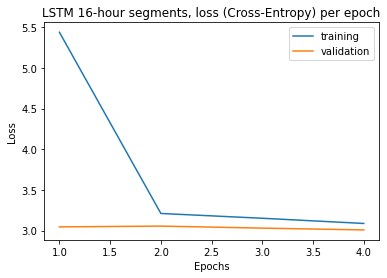

In [311]:
average_loss = [5.44,3.21,3.1511,3.0871666666666666]
average_val_loss = [3.0449333333333333,3.0545333333333335,3.029733333333333,3.007633333333333]

plt.plot(range(1, len(average_loss) + 1), average_loss)
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.title('LSTM 16-hour segments, loss (Cross-Entropy) per epoch')
plt.show()

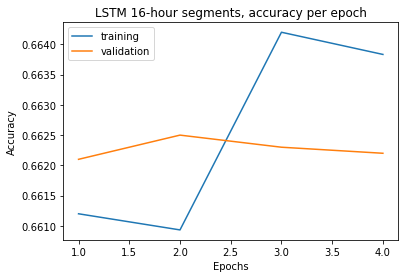

In [309]:
average_loss = [0.6612,0.6609333333333334,0.6642,0.6638333333333334]
average_val_loss = [0.6621,0.6625,0.6623,0.6622]

plt.plot(range(1, len(average_loss) + 1), average_loss)
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.title('LSTM 16-hour segments, accuracy per epoch')
plt.show()

In [230]:
test_data = X_test_scaled_res 
test_targets = test_labels

In [231]:
history_test = model.fit(train_data, train_targets,
                        epochs=12, batch_size=16, verbose=1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/12
1244/1244 [==============================] - 1075s 860ms/step - loss: nan - accuracy: 0.6423
Epoch 2/12
1244/1244 [==============================] - 1142s 918ms/step - loss: nan - accuracy: 0.6501
Epoch 3/12
1244/1244 [==============================] - 1125s 905ms/step - loss: nan - accuracy: 0.6477
Epoch 4/12
1244/1244 [==============================] - 1088s 875ms/step - loss: nan - accuracy: 0.6412
Epoch 5/12
1244/1244 [==============================] - 1093s 879ms/step - loss: nan - accuracy: 0.6472
Epoch 6/12
1244/1244 [==============================] - 1118s 899ms/step - loss: nan - accuracy: 0.6399
Epoch 7/12
1244/1244 [==============================] - 1070s 860ms/step - loss: nan - accuracy: 0.6507
Epoch 8/12
1244/1244 [==============================] - 1150s 925ms/step - loss: nan - accuracy: 0.6452
Epoch 9/12
1244/1244 [==============================] - 1037s 833ms/step - loss: nan - accuracy: 0.6419
Epoch 10/12
1244/1244 [==============================] - 984s 79

In [300]:
y_pred = model.evaluate(X_test_scaled_res,test_labels)
#print(y_pred)
#print(test_labels)

157/157 [==============================] - 15s 96ms/step - loss: 1.0575 - accuracy: 0.6533


In [302]:
print(y_pred)
print(test_labels.shape)

[1.05751371383667, 0.6533306837081909]
(4999, 1)
